# Predicting Taiwan Credit Card Default

## Introduction 

The dataset we are working with is collection of client specifications and history from a taiwan credit card company that is coupled with their credit card default status. Throughout this notebook we explore various trends with the data, process the data, and create optomized machine learning classifiers to predict a client's likelihood to default.




In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing as skp
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


dat = pd.read_csv("https://raw.githubusercontent.com/DerekMcFate/MachineLearningProject/master/default_cc_train.csv")

## Data Preprocessing

We renamed the data column 'default.payment.next.month' to 'DEFAULT' in order to make it easier to work with. The Education and Marriage columns had zero values that didn't have any explaination, so we decided to remove them from the dataset. Education contained values from 0-6, but there weren't any descriptions for 5 and 6, so we merged them both into 5.

In [15]:
# Rename our label as "DEFAULT"
dat = dat.rename(index=str, columns={"default.payment.next.month": "DEFAULT"})

# Throw away education=0 and marriage=0, and combine education=5,6 as both are 'unknown'
dat['EDUCATION'].replace(6, 5, inplace=True)
dat = dat[dat['EDUCATION'] != 0]

dat = dat[dat.MARRIAGE != 0]

## Data Exploration

In this plot we show the density of Ages that are represented in the dataset. Most of the people are in their 20's and 30's.

/Users/scrambles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


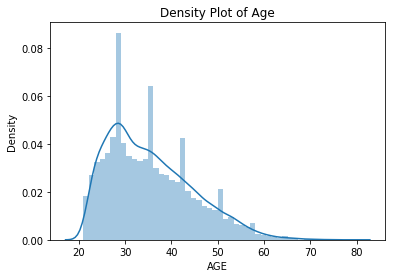

In [16]:
fig = sns.distplot(dat["AGE"])
plt.xlabel("AGE")
plt.ylabel("Density")
plt.title("Density Plot of Age") 
plt.show(fig)

Here are the percentage of each sex that defaults with 1 representing male and 2 representing female. The percentage of males that default are slightly higher than the percentage females. This is with the data set being mostly female.

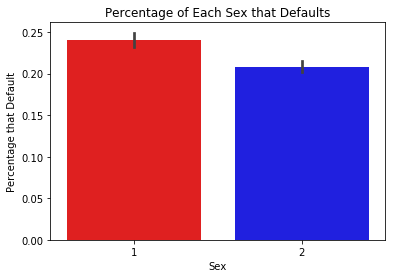

2    15072
1     9871
Name: SEX, dtype: int64

In [17]:
#men barely more likel to default
fig = sns.barplot(dat["SEX"],dat["DEFAULT"],palette=["red","blue"])
plt.xlabel("Sex")
plt.ylabel("Percentage that Default")
plt.title("Percentage of Each Sex that Defaults") 
plt.show(fig)
#more women
dat["SEX"].value_counts()


Here we show the percentage that default from each education level. The lower three levels are far more likely to default than the last two.

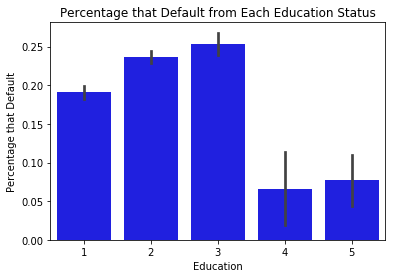

In [18]:
#more likely to default with 1-3 eduction level
fig = sns.barplot(dat["EDUCATION"],dat["DEFAULT"],palette=["blue"])
plt.xlabel("Education")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default from Each Education Status") 
plt.show(fig)

Looking at marriage status there doesn't seem to be to big of a difference between marriage status and the percentage that that group defaults.

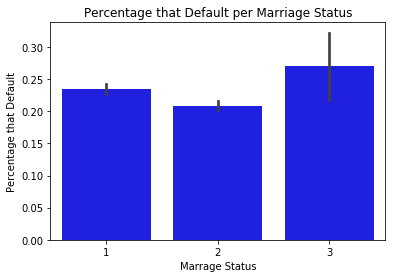

In [19]:
#looks like un married is less likely to default
fig = sns.barplot(dat["MARRIAGE"],dat["DEFAULT"],palette=["blue"])
plt.xlabel("Marrage Status")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default per Marriage Status") 
plt.show(fig)

Here are the percentage that each payment delay status will default for the months of may and september. A few key trends to note is that if the balance is paid off completely then the client is very unlikely to default while if there are one or more months of not paying they are more likely to default. Also it is interesting to note that if a client has not paid for eight months in may they 100% default while it is 50-50 chance of them defaulting in the most recent month(september) with eight months not paid.

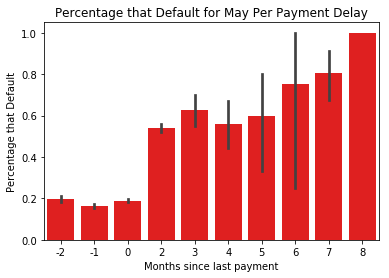

In [20]:
#if you're at a level 8 bad boi on these months you default 100%
fig = sns.barplot(dat["PAY_5"],dat["DEFAULT"],palette=["red"])
plt.xlabel("Months since last payment")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default for May Per Payment Delay") 
plt.show(fig)

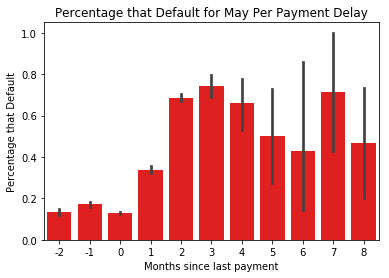

In [21]:
#if youre at 8 months no pay 50-50 chance to default
fig = sns.barplot(dat["PAY_0"],dat["DEFAULT"],palette=["red"])
plt.xlabel("Months since last payment")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default for May Per Payment Delay") 
plt.show(fig)

## Machine Learning

### Logistic Regression Model

Let us try classifying using a logistic regression model. First we split our data into testing and training sets. From there, we can fit the data to our model and test it. We can see that the accuracy of the model is in the upper 70s.  

In [22]:
X = dat.drop(columns=['DEFAULT'])
y = dat['DEFAULT']

#scaler = skp.StandardScaler()
#dat = scaler.fit_transform(X)

logi = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
logi.fit(pd.DataFrame(X_train), y_train)
logi.score(pd.DataFrame(X_test), y_test)

0.7805171377029465

Here we create a function to plot the learning curve of our model. In the case of our Logistic Model, both lines reach their finalized values relatively quickly

Plotting the learning curve. it looks clean. 

<module 'matplotlib.pyplot' from '/Users/scrambles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

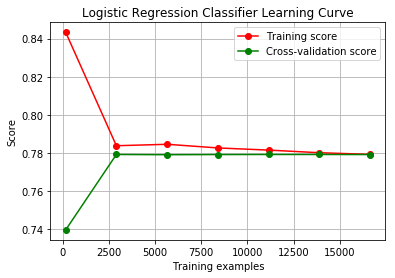

In [23]:
def plot_learning_curve(estimator, title, X, y, train_sizes=np.linspace(.01, 1.0, 7)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=None, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(logi, "Logistic Regression Classifier Learning Curve", X, y)

However, despite the score and clarity of the learning curve, we can see the fault in the model if we look at the confusion matrix. This model effectively only gives a single answer almost every time. So the accuracy of the model directly correlates with the percentage of the non-defaulting labels within our data. 

In [24]:
pred = logi.predict(pd.DataFrame(X_test))
confusion_matrix(y_test, pred)

array([[3894,    0],
       [1095,    0]])

If we look at the percentage of 0s in the labels, we can see that our model slightly varies from only guessing 'not default'

In [25]:
y.value_counts()[0]/len(y)

0.7791364310628233

### SVM
If we use a support vector machine without the use of kernals, we can get roughly the same accuracy as we did with the logistic regression model.

In [26]:
sv = SVC()
sv.fit(X_train, y_train)
sv.score(X_test, y_test)

0.7805171377029465

The resulting confusion matrix from the SVM shows that the same problem is occuring. This means that we must transform our data or derive more data that fits better with our models. 

In [27]:
pred = sv.predict(pd.DataFrame(X_test))
confusion_matrix(y_test, pred)

array([[3894,    0],
       [1095,    0]])

### Naive Bayes Model

We decided to use a Naive Bayes classifier on this dataset as our second model. We were expecting the model to have trouble on this data set due to the large number of variables, but it could do well because it has a large amount of training data to look at.

In [28]:
nb = GaussianNB()
nb.fit(pd.DataFrame(X_train), y_train)
pred = nb.predict(X_test)
print(nb.score(pd.DataFrame(X_test), y_test))
print(confusion_matrix(y_test, pred))

0.40348767288033677
[[1106 2788]
 [ 188  907]]


<module 'matplotlib.pyplot' from '/Users/scrambles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

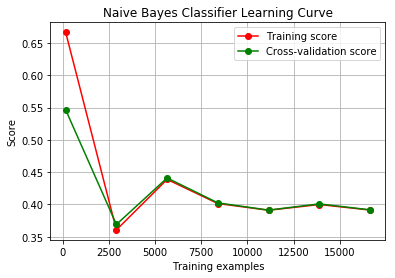

In [29]:
plot_learning_curve(nb, "Naive Bayes Classifier Learning Curve", X, y)


The Naive Bayes model did not perform well on this dataset. It was accurate on less than half of the test set, and the learning curve shows that the model did well with approimately 6000 entries, but began to fall off as the training set got larger.

### Decision Tree Model

We decided to use a Decision Tree classifier to see how well it was able to label and make predictions on the numerical data. We were expecting this classifier to be accurate more than 50% of the time, but not as accurate as Logistic Regression.

In [30]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(pd.DataFrame(X_train), y_train)
print(dtc.score(pd.DataFrame(X_test), y_test))
pred = dtc.predict(X_test)
print(confusion_matrix(y_test, pred))

0.7280016035277611
[[3184  710]
 [ 647  448]]


<module 'matplotlib.pyplot' from '/Users/scrambles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

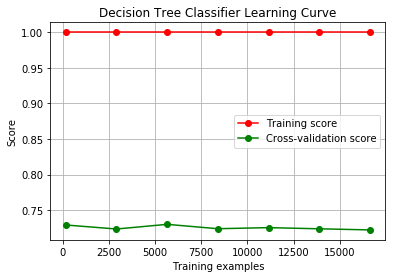

In [31]:
plot_learning_curve(dtc, "Decision Tree Classifier Learning Curve", X, y)

The Decision Tree classifier performed better than expected, as it was almost as accurate as Logistic Regression with its predictions. There isn't a lot of information to be gained from the learning curve, as neither changed dramtically as the training set got larger. It performed with 100% accuracy on the training set, and slightly less than 75% on the test set.